In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model

## Extracting Files

In [ ]:
c = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID'
n = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal'
p = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia'
ct = '/content/drive/MyDrive/HRCT COVID/CT COVID'
nct = '/content/drive/MyDrive/HRCT COVID/CT NORMAL'

In [ ]:
random.seed(42)
filenames = os.listdir(nct) + os.listdir(ct) +  os.listdir(c) + random.sample(os.listdir(n), 4000) + os.listdir(p)

### Classes
* 0 -> Normal
* 1 -> Viral Pneumonia
* 2 -> COVID
* 3 -> CT COVID
* 4 -> CT NORMAL


In [ ]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'CT NORMAL':
        categories.append(str(4))
    elif category == 'CT COVID':
        categories.append(str(3))
    elif category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [ ]:
for i in range(len(filenames)):
    if 'CT NORMAL' in filenames[i]:
        filenames[i] = os.path.join(nct, filenames[i])
    elif 'CT COVID' in filenames[i]:
        filenames[i] = os.path.join(ct, filenames[i])
    elif 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head(6000)

,filename,category
0,/content/drive/MyDrive/HRCT COVID/CT NORMAL/CT...,4
1,/content/drive/MyDrive/HRCT COVID/CT NORMAL/CT...,4
2,/content/drive/MyDrive/HRCT COVID/CT NORMAL/CT...,4
3,/content/drive/MyDrive/HRCT COVID/CT NORMAL/CT...,4
4,/content/drive/MyDrive/HRCT COVID/CT NORMAL/CT...,4
...,...,...
5995,/content/drive/MyDrive/COVID-19_Radiography_Da...,0
5996,/content/drive/MyDrive/COVID-19_Radiography_Da...,0
5997,/content/drive/MyDrive/COVID-19_Radiography_Da...,0
5998,/content/drive/MyDrive/COVID-19_Radiography_Da...,0


## Exploratory Data Analysis

In [ ]:
pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 7.9 MB/s 
     |████████████████████████████████| 957 kB 51.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.5.3


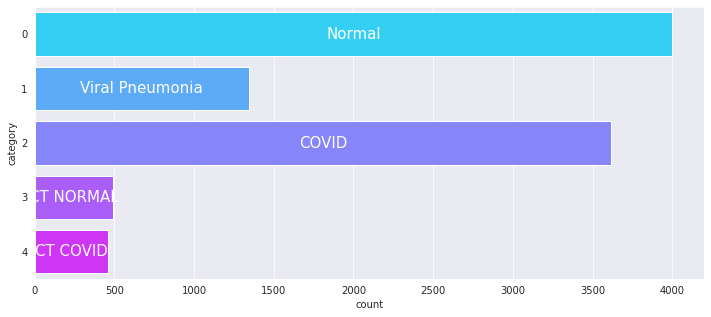

In [ ]:
plt.figure(figsize=(12,5))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0],
              labels=['Normal', 'Viral Pneumonia','COVID', 'CT NORMAL', 'CT COVID'],
              label_type='center', size=15, color='w')
plt.show()

## Data Visualization

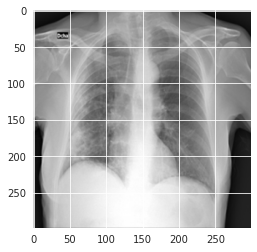

In [ ]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [ ]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [ ]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 7934 validated image filenames belonging to 5 classes.


In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 992 validated image filenames belonging to 5 classes.


## Model Training - VGG16

#### Model Architecture

In [ ]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

#### Model Summary

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### Optimizer - Adam

In [ ]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 100
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/100
529/529 [==============================] - 2787s 5s/step - loss: 0.6503 - accuracy: 0.7308 - val_loss: 0.3989 - val_accuracy: 0.8468
Epoch 2/100
529/529 [==============================] - 119s 226ms/step - loss: 0.4381 - accuracy: 0.8243 - val_loss: 0.3213 - val_accuracy: 0.8629
Epoch 3/100
529/529 [==============================] - 119s 225ms/step - loss: 0.3712 - accuracy: 0.8485 - val_loss: 0.3008 - val_accuracy: 0.8760
Epoch 4/100
529/529 [==============================] - 118s 223ms/step - loss: 0.3330 - accuracy: 0.8677 - val_loss: 0.2740 - val_accuracy: 0.8780
Epoch 5/100
529/529 [==============================] - 118s 223ms/step - loss: 0.3093 - accuracy: 0.8740 - val_loss: 0.2358 - val_accuracy: 0.9052
Epoch 6/100
529/529 [==============================] - 119s 225ms/step - loss: 0.2847 - accuracy: 0.8907 - val_loss: 0.2554 - val_accuracy: 0.8962
Epoch 7/100
529/529 [==============================] - 118s 224ms/step - loss: 0.2795 - accuracy: 0.8910 - val_loss: 0.2

## Saving Model

In [ ]:
#model.save('Covid.h5')

## Plotting
* Training & Validation Loss
* Training & Validation Loss

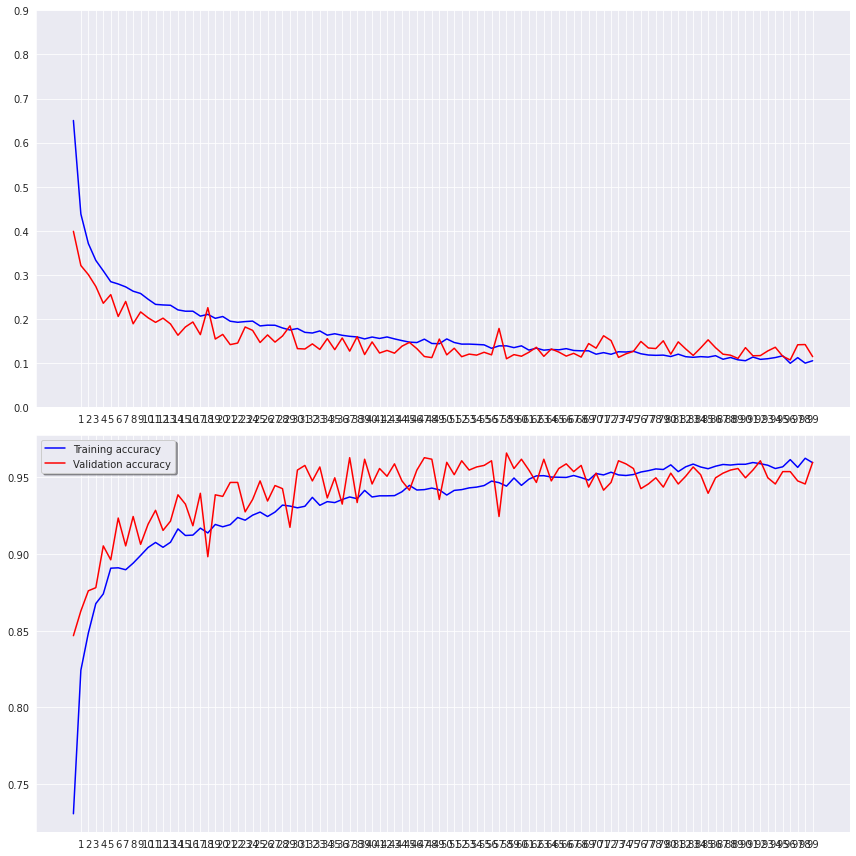

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Model Testing

True value is : Normal
Prediction is:
Normal


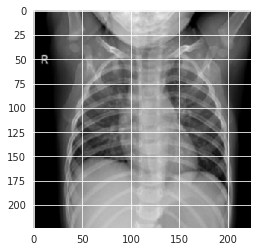

In [ ]:
sample = random.choice(test_data['filename'])


category = sample.split('-')[0]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')

image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID +")

plt.imshow(image)

In [ ]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy",history.history['val_accuracy'][-1])

training_accuracy 0.9594151973724365
validation_accuracy 0.9596773982048035
